**Testing highly variable genes**


Goal: Compare different methods for identifying highly variable genes (built into scanpy) and identifying optimal number of features to use

1. Load in 30k dataset with original labels
2. Create cross-fold splits using StratifiedGroupKFold
3. Select highly variable genes using seurat_v3, seurat (v1), Cell Ranger, or analytic Pearson residuals methods
4. Train model using top 20, 50, 100, 200, 500, 1000, 2000, or 5000. Also do the same for randomly selected genes (randomize order of all genes and select top N or randomly select N genes).
5. Plot all evaluation metrics for all approaches



In [1]:
# Install packages
#!pip install --upgrade "cupy-cuda12x"
#!pip install scanpy[skmisc]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set up paths to files
main_dir = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/'
data_path = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/Capstone - Shared folder/Data/'

# Change into correct directory for importing custom preprocessing function
%cd {main_dir}scripts/Cancer_Prediction_10x
# %pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/scripts/Cancer_Prediction_10x


In [3]:
from main_functions import *
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score,\
                            balanced_accuracy_score, matthews_corrcoef, roc_auc_score, RocCurveDisplay, auc, average_precision_score, make_scorer

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

In [4]:
# Constants
RANDOM_STATE = 42
CV = 5

In [8]:
# Load training dataset into AnnData object
adata_30k = create_adata_train(data_path + 'EMTAB8107_2102-Breastcancer_counts',
                               data_path + 'BRCA_EMTAB8107_expression.h5',
                               data_path + 'EMTAB8107_2103-Breastcancer_metadata.csv.gz')

Dataset has 33043 cells and 22830 features
Size of raw dataset: 
Size: 554.77 MB
Size of normalized dataset:
Size: 558.64 MB


In [5]:
# Variables for training
clf = XGBClassifier(max_depth = 4, n_estimators = 50, random_state = RANDOM_STATE)
num_features = [20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
feat_sel_list = ['seurat_v3', 'seurat', 'cell_ranger', 'pearson_residuals',\
                 'random_all_genes', 'random_per_num']

In [ ]:
# For XGBoost, compare different numbers of features and different methods for selecting highly variable genes
results_df = train_feat_loop_cv(clf, adata_30k, 'PatientNumber', num_features, feat_sel_list,
                                random_state = RANDOM_STATE, k_fold = 5)
print(results_df.shape)
display(results_df.head())
results_df.to_csv(data_path + 'results_df_all_std_featsel.csv')

,f1,accuracy,balanced_accuracy,recall,precision,average_precision,roc_auc,matthews_corrcoef,fold,feat_sel_type,num_features
0,0.235440,0.856445,0.564667,0.171790,0.374016,0.170813,0.564667,0.183644,0,seurat_v3,20
1,0.363636,0.884365,0.616909,0.256781,0.622807,0.255551,0.616909,0.349301,0,seurat_v3,50
2,0.557159,0.907166,0.713993,0.453888,0.721264,0.397638,0.713993,0.525328,0,seurat_v3,100
3,0.617092,0.919730,0.742010,0.502712,0.798851,0.465575,0.742010,0.594107,0,seurat_v3,200
4,0.681514,0.933457,0.771466,0.553345,0.886957,0.548262,0.771466,0.669053,0,seurat_v3,300


,feat_sel_type,num_features,fold,metric,score
0,seurat_v3,20,0,f1,0.235440
1,seurat_v3,50,0,f1,0.363636
2,seurat_v3,100,0,f1,0.557159
3,seurat_v3,200,0,f1,0.617092
4,seurat_v3,300,0,f1,0.681514


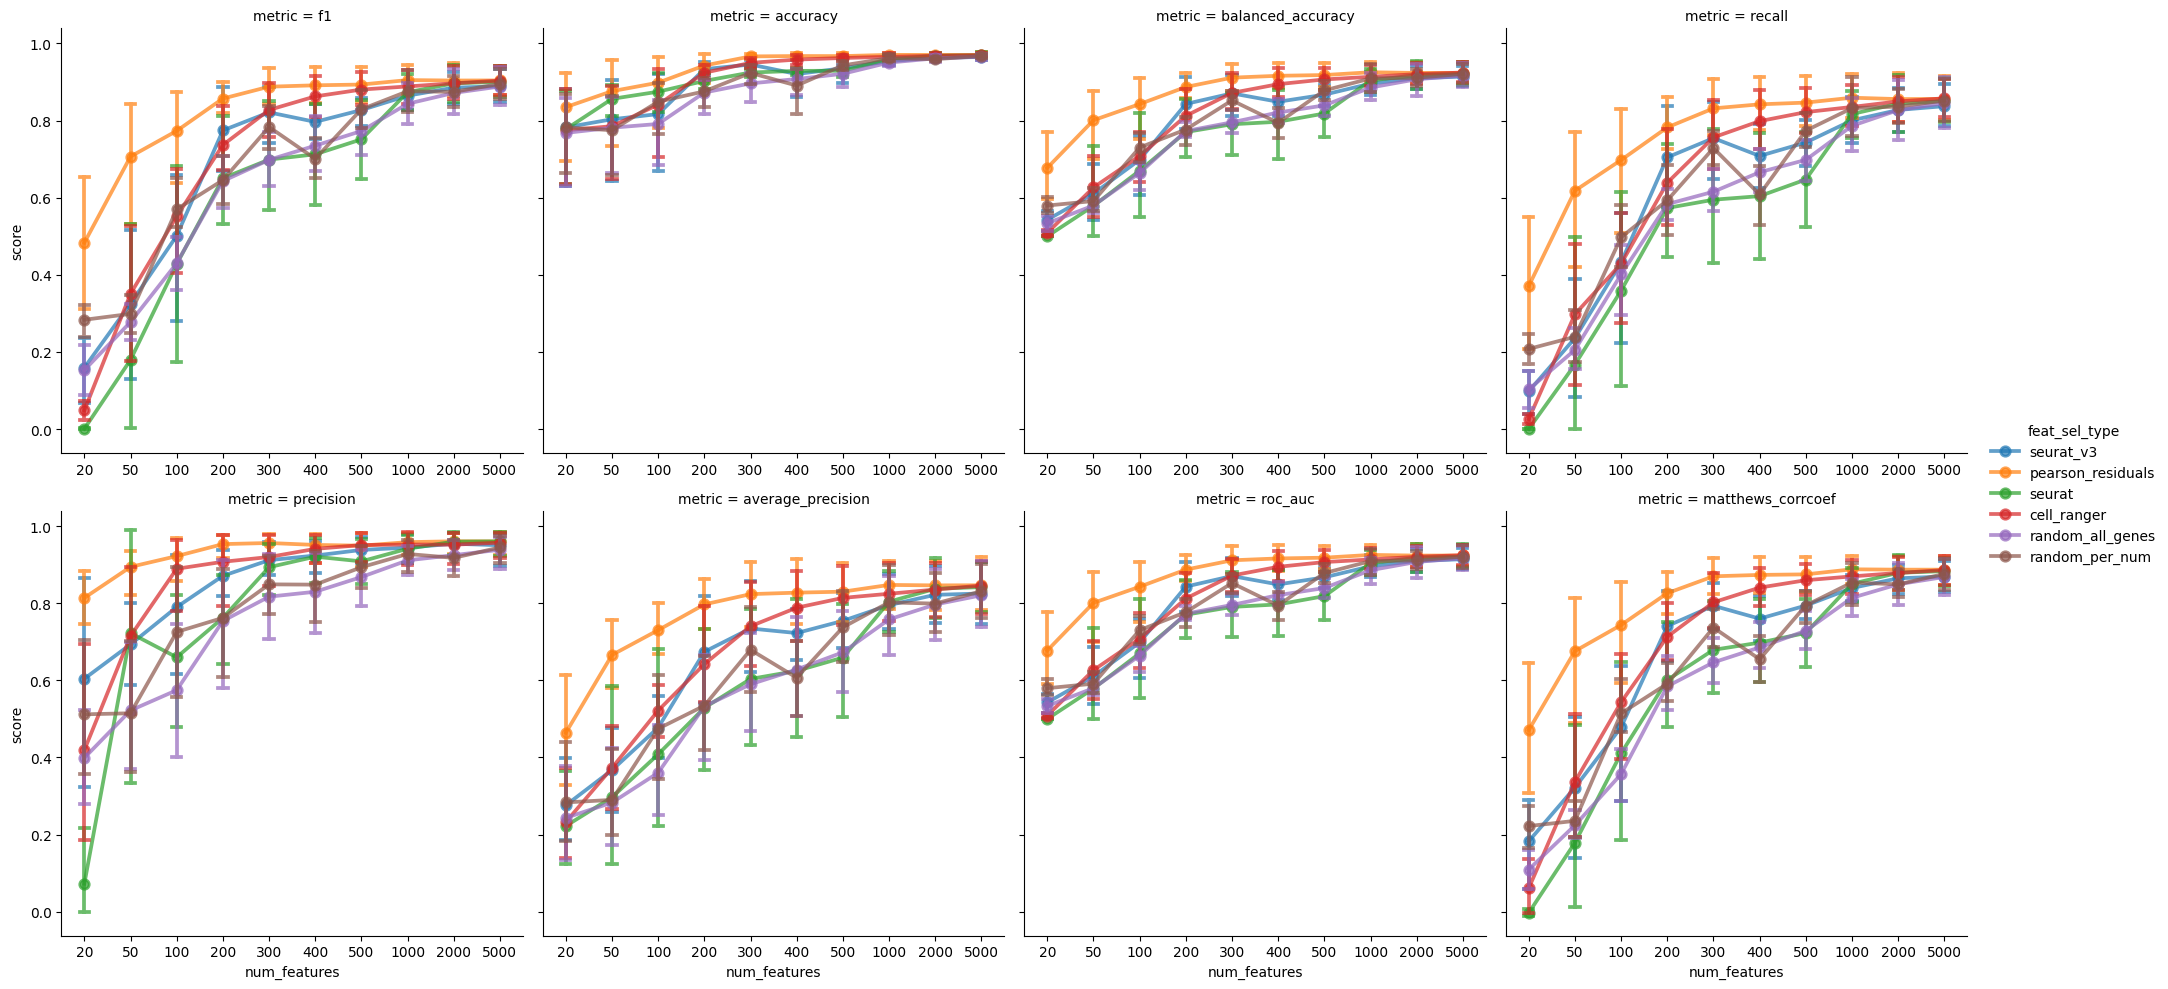

In [6]:
results_df = pd.read_csv(main_dir + 'scripts/Outputs/results_df_cv_20241108.csv', index_col = 0)
display(results_df.head())

# Print figures of metrics
fig1 = make_line_plots_metrics(results_df)
fig1.savefig(main_dir + 'scripts/Outputs/fig1_metrics.png')

,feat_sel_type,num_features,fold,metric,score
0,seurat_v3,20,0,f1,0.235440
1,seurat_v3,50,0,f1,0.363636
2,seurat_v3,100,0,f1,0.557159
3,seurat_v3,200,0,f1,0.617092
4,seurat_v3,300,0,f1,0.681514


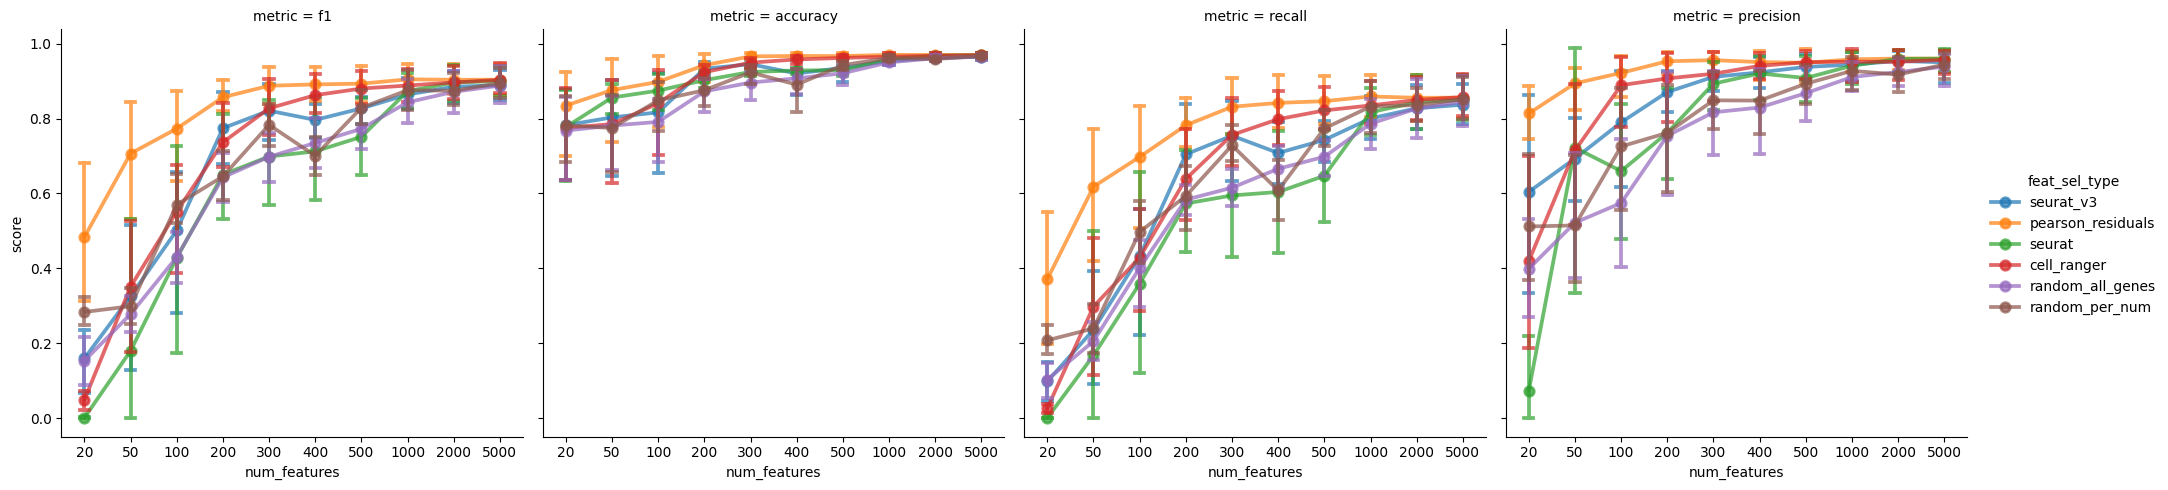

In [8]:
# Save version of figure with 4 metrics: F1, accuracy, recall, precision
results_df_sub = results_df[['f1', 'accuracy', 'recall', 'precision', 'feat_sel_type', 'num_features', 'fold']]

fig1b = make_line_plots_metrics(results_df_sub)
fig1b.savefig(main_dir + 'scripts/Outputs/fig1b_metrics.png')

Main findings

* Comparison of methods
  * Analytic Pearson residuals performs the best
  * Seurat v1 performs similarly to random
  * Seurat v3 and Cell Ranger are generally similar
  * Besides Pearson, there is a modest improvement in performance vs random, particularly when number of features is less than 1000
* Optimal number of features:
  * See sharp increase in scores until ~200-300, after which there is a gradual increase in scores

Conclusions:
* Use analytic Pearson residuals with 300 genes

